# Imports 

In [231]:
import os
import random 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, Flatten, Dropout, Input, GlobalMaxPooling1D, concatenate

sacando codigos de folder

In [232]:
path = "C:/Users/e1000/OneDrive/Documents/UNIVERSIDAD/Compladores e IA/reto/Plagiarism-Detector-with-Markov-Chains-and-CNNs/Dataset/version_2"


# Lista de carpetas en el dataset original
folder_group = [name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]

# DataFrame 
Definimos nuestro DataFrame, Path, y empezamos con la lectura de los archivos de Java con UTF-8. El DataFrame contendra los codigos a procesar.

In [233]:
df = pd.DataFrame(columns=['Nombre1','Code1','Nombre2', 'Code2'])

In [234]:
import os
import pandas as pd

path = "C:/Users/e1000/OneDrive/Documents/UNIVERSIDAD/Compladores e IA/reto/Plagiarism-Detector-with-Markov-Chains-and-CNNs/Dataset/version_2"

# Lista de carpetas en el dataset original
folder_group = [name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]

df = pd.DataFrame(columns=['Nombre1','Code1','Nombre2', 'Code2'])

for folder in folder_group:
    dataset1 = []
    dataset2 = []

    folder_path = os.path.join(path, folder)
    problem_list = os.listdir(folder_path)

    # Eliminar extensión ".java" del nombre del archivo
    problem_list = [os.path.splitext(file)[0] for file in problem_list]

    # Leer el primer archivo .java con UTF-8
    with open(os.path.join(folder_path, problem_list[0] + '.java'), 'r', encoding='utf-8') as file1:
        dataset1.append(file1.read())
    d1 = ' '.join(dataset1)

    # Leer el segundo archivo .java con UTF-8
    with open(os.path.join(folder_path, problem_list[1] + '.java'), 'r', encoding='utf-8') as file2:
        dataset2.append(file2.read())
    d2 = ' '.join(dataset2)

    # Añadir datos al DataFrame
    df.loc[len(df.index)] = [problem_list[0], d1, problem_list[1], d2]


# Processamiento de Texto
Cargamos la informacion de nuestro dataset y verificamos que se cargen correctamente.

In [235]:
def load_data_from_directory(directory):
    texts = []
    labels = []
    # print(directory)
    for label in os.listdir(directory):
        # print(label)
        # class_dir = os.path.join(directory, label)
        class_dir = os.path.join(directory)
        # print(class_dir)
        if label.endswith(".txt"):
            file_path = os.path.join(class_dir, label)
            # print(file_path)
            with open(file_path, 'r', encoding='utf-8') as file:
                texts.append(file.read())
                labels.append(label)
                # print(texts)
    return texts, labels

# Ruta a la carpeta que contiene las subcarpetas 'java', 'python', y 'c'
data_directory = 'C:/Users/e1000/OneDrive/Documents/UNIVERSIDAD/Compladores e IA/reto/Plagiarism-Detector-with-Markov-Chains-and-CNNs/reto'

# Cargar datos desde las carpetas de Java, Python y C
java_texts, java_labels = load_data_from_directory(os.path.join(data_directory, 'javaText'))
# python_texts, python_labels = load_data_from_directory(os.path.join(data_directory, 'pythonText'))
# c_texts, c_labels = load_data_from_directory(os.path.join(data_directory, 'cText'))

# Verificar que los datos se han cargado correctamente
print(f'Java texts: {len(java_texts)}')
# print(f'Python texts: {len(python_texts)}')
# print(f'C texts: {len(c_texts)}')

# Unir todos los textos y etiquetas
texts = java_texts #+ python_texts + c_texts
labels = java_labels #+ python_labels + c_labels

# Verificar los tamaños de los textos y etiquetas combinados
print(f'Total texts: {len(texts)}')
print(f'Total labels: {len(labels)}')


Java texts: 1235
Total texts: 1235
Total labels: 1235


# Remover Comentarios
Utilizando expresiones regulares, nos deshacemos de commentarios.

In [236]:
import re

def remove_comments(text):
    # Remove all block comments (/* */)
    text = re.sub(r'/\*.*?\*/', '', text, flags=re.DOTALL)
    # Remove all line comments (//)
    text = re.sub(r'//.*', '', text)
    # Remove all Python line comments (#)
    text = re.sub(r'#.*', '', text)
    # Remove all Python block comments (''' ''')
    text = re.sub(r"'''(.*?)'''", '', text, flags=re.DOTALL)
    # Remove all Python block comments (""" """)
    text = re.sub(r'"""(.*?)"""', '', text, flags=re.DOTALL)
    
    # Split the text into lines, clean empty lines
    lines = text.split('\n')
    cleaned_lines = [line for line in lines if line.strip() != '']
    
    cleaned_text = '\n'.join(cleaned_lines)
    return cleaned_text

# Ejemplo de uso
code = """/* Block comment */
int x = 0; // Line comment

x++; /* Another block
comment */

System.out.println(x); // Print x

# This is a Python comment
y = 2 # Another Python comment

''' Python block comment
spanning multiple lines '''
z = 3; // C style line comment

"""
cleaned_code = remove_comments(code)
print(cleaned_code)


int x = 0; 
x++; 
System.out.println(x); 
y = 2 
z = 3; 


# Calculo de Similitudes
Realizamos el calculo de similitudes con trancisiones de Markov, inicialmente creando la matriz de transcicion a traves del texto, y realizando la similitud de cosenos.

In [237]:
def create_transition_matrix(text, words):
  # Inicializar la matriz de transición
  matrix = np.zeros((len(words), len(words)))

  # Dividir el texto en palabras
  word_list = text.split()

  # Calcular las frecuencias de las transiciones entre palabras
  for i in range(len(word_list) - 1):
      current_word = word_list[i]
      next_word = word_list[i + 1]

      current_index = words.index(current_word)
      next_index = words.index(next_word)

      matrix[current_index][next_index] += 1

  # Normalizar las filas de la matriz, evitando divisiones por cero
  row_sums = matrix.sum(axis=1)
  nonzero_rows = np.nonzero(row_sums)
  matrix_normalized = np.zeros_like(matrix)
  matrix_normalized[nonzero_rows, :] = matrix[nonzero_rows, :] / row_sums[nonzero_rows, np.newaxis]

  return matrix_normalized

Funcion para obtener archivos.

In [238]:
def get_file(file):
    return open(file, 'r', encoding='utf-8', errors='ignore').read()

Funcion de separacion de palabras.

In [239]:
def split_words(text1, text2):
  splitted_words = list(set(text1.split() + text2.split()))
  return splitted_words

Claculo de la similitud de coseno.

In [240]:
def cos_ang(mat1, mat2):
  mat2T = np.transpose(mat2)
  c = np.dot(mat2T, mat1)
  prod_int = np.trace(c)
  normA = np.sqrt(np.trace((np.dot(np.transpose(mat1), mat1))))
  normB = np.sqrt(np.trace((np.dot(np.transpose(mat2), mat2))))

  return prod_int / (normA * normB)

In [241]:
def get_words(text):
  file = open(text, "r", encoding = 'utf-8', errors ='ignore')
  words = file.read()
  file.close()

  punctuation = ["_", "-", ".", ":", "," , ";", "(", ")", "?", "¿", "¡", "!"]
  for i in punctuation:
      words = words.replace(i, " ")

  words = words.lower()
  words = words.replace('\n', ' ')

  return words

# Generar Tabla de Similitudes
Generamos nuestra tabla de similitudes/Realiza la evaluacion de la similitud de textos utilizando las funciones anteriores.

In [242]:
def similitud(text1, text2):
  data1 = remove_comments(text1)
  data2 = remove_comments(text2)

  split_data = split_words(data1, data2)

  mat1 = create_transition_matrix(data1, split_data)
  mat2 = create_transition_matrix(data2, split_data)
  cos = cos_ang(mat1, mat2)

  return cos*100 # Debe retornar un valor %cos

Obtenemos pruebas aleatoreamente del Dataset.

In [243]:
def get_two_random_texts(texts):

  if len(texts) <= 1:
    raise ValueError("The provided list of texts must contain at least two elements.")

  first_text_index = random.randint(0, len(texts) - 1)
  second_text_index = random.randint(0, len(texts) - 1)

  # Ensure distinct texts are returned
  while first_text_index == second_text_index:
    second_text_index = random.randint(0, len(texts) - 1)

  return texts[first_text_index],texts[second_text_index]


In [244]:
similitud(get_two_random_texts(texts)[0], get_two_random_texts(texts)[1])

11.00515588009085

In [245]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity_score(text1, text2):
    vectorizer = TfidfVectorizer().fit_transform([text1, text2])
    vectors = vectorizer.toarray()
    cos_sim = cosine_similarity(vectors)
    return cos_sim[0, 1]*100


In [246]:
!pip install Levenshtein

In [247]:
import Levenshtein

def levenshtein_distance(text1, text2):
    return Levenshtein.distance(text1, text2)


In [248]:
from sklearn.metrics.pairwise import manhattan_distances

def manhattan_distance_score(text1, text2):
    vectorizer = TfidfVectorizer().fit_transform([text1, text2])
    vectors = vectorizer.toarray()
    manhattan_dist = manhattan_distances(vectors)
    return manhattan_dist[0, 1]


Agregamos una columna de Similitud dependiendo del Resultado, y una identificada como Plagio si la similitud es mayor al 80%.

In [249]:
df['Similitud'] = df.apply(lambda row: similitud(row['Code1'], row['Code2']), axis=1)

df['Similitud_Coseno'] = df.apply(lambda row: cosine_similarity_score(row['Code1'], row['Code2']), axis=1)
df['Distancia_Levenshtein'] = df.apply(lambda row: levenshtein_distance(row['Code1'], row['Code2']), axis=1)
df['Distancia_Manhattan'] = df.apply(lambda row: manhattan_distance_score(row['Code1'], row['Code2']), axis=1)


In [250]:
# Obtener el valor máximo de la columna 'Distancia_Manhattan'
max_distancia_manhattan = df['Distancia_Manhattan'].max()

# Calcular el factor de escala
factor_escala = 10 / max_distancia_manhattan

# Función para normalizar e invertir la distancia
def normalizar_e_invertir(distancia, factor, max_valor):
    normalizada = distancia * factor
    invertida = 10 - normalizada
    return max(1, min(10, invertida))*10

df['Distancia_Manhattan'] = df['Distancia_Manhattan'].apply(lambda x: normalizar_e_invertir(x, factor_escala, max_distancia_manhattan))



In [251]:
# Obtener el valor máximo de la columna 'Distancia_Levenshtein'
max_distancia_levenshtein = df['Distancia_Levenshtein'].max() 

# Función para normalizar e invertir la distancia de Levenshtein
def normalizar_e_invertir_levenshtein(distancia, max_valor):
    normalizada = (distancia / max_valor) * 10
    invertida = 10 - normalizada
    return max(0, min(10, invertida))*10

df['Distancia_Levenshtein'] = df['Distancia_Levenshtein'].apply(lambda x: normalizar_e_invertir_levenshtein(x, max_distancia_levenshtein))



In [252]:
df

,Nombre1,Code1,Nombre2,Code2,Similitud,Similitud_Coseno,Distancia_Levenshtein,Distancia_Manhattan
0,0017d438,import java.io.BufferedReader;\nimport java.io...,9852706b,import java.io.BufferedReader;\nimport java.io...,19.948276,65.986167,93.908235,62.369377
1,0017d438,import java.io.BufferedReader;\nimport java.io...,ac180326,import java.io.BufferedReader;\nimport java.io...,12.710559,58.223706,91.786918,47.903960
2,0048a372,import java.io.*;\nimport java.util.*;\n\npubl...,0adb1ee5,import java.util.*;\n// import java.lang.*;\ni...,10.224491,43.734238,92.512745,51.367918
3,00af3420,import java.util.*;\nimport java.io.*;\n\npubl...,5449d33c,import java.io.*;\nimport java.util.*;\nimport...,13.862249,52.947792,96.254212,56.215158
4,00af3420,import java.util.*;\nimport java.io.*;\n\npubl...,86102d81,import java.io.*;\nimport java.util.*;\n\t\t\n...,19.701471,57.087980,95.200035,60.856138
...,...,...,...,...,...,...,...,...
906,eea69e7f,import java.util.*;\n\npublic class Solution {...,f6ca6fc8,import java.util.*;\nimport java.io.*;\n\npubl...,15.404823,49.469676,97.036205,67.534280
907,f229aa7f,import java.util.*;\nimport java.io.*;\nimport...,fcc7e8fa,import java.io.OutputStream;\nimport java.io.I...,17.686890,33.898958,93.549641,52.642304
908,f28b8cb4,import java.io.BufferedReader;\nimport java.io...,ff3283cf,import java.util.*;\nimport java.lang.*;\nimpo...,14.593163,58.860077,94.677266,56.882845
909,fadc1365,import java.io.PrintWriter;\nimport java.io.Bu...,fdd85afb,import java.util.*;\n\npublic class Solution{\...,9.334347,58.875115,94.033526,59.120000


In [253]:

df['Promedio_Ponderado'] = (0.4 * df['Similitud'] + 
                             0.3 * df['Similitud_Coseno'] + 
                             0.2 * df['Distancia_Levenshtein'] + 
                             0.1 * df['Distancia_Manhattan'])


umbral = 50

def determinar_plagio(promedio):
    if promedio > umbral:
        return 1
    else:
        return 0

df['Plagio'] = df['Promedio_Ponderado'].apply(determinar_plagio)

print(df[['Promedio_Ponderado', 'Plagio']])


     Promedio_Ponderado  Plagio
0             52.793745       1
1             45.699115       0
2             40.849409       0
3             46.301595       0
4             50.132603       1
..                  ...     ...
906           47.163501       0
907           41.218602       0
908           48.119026       0
909           46.114979       0
910          100.000000       1

[911 rows x 2 columns]


In [254]:
df

,Nombre1,Code1,Nombre2,Code2,Similitud,Similitud_Coseno,Distancia_Levenshtein,Distancia_Manhattan,Promedio_Ponderado,Plagio
0,0017d438,import java.io.BufferedReader;\nimport java.io...,9852706b,import java.io.BufferedReader;\nimport java.io...,19.948276,65.986167,93.908235,62.369377,52.793745,1
1,0017d438,import java.io.BufferedReader;\nimport java.io...,ac180326,import java.io.BufferedReader;\nimport java.io...,12.710559,58.223706,91.786918,47.903960,45.699115,0
2,0048a372,import java.io.*;\nimport java.util.*;\n\npubl...,0adb1ee5,import java.util.*;\n// import java.lang.*;\ni...,10.224491,43.734238,92.512745,51.367918,40.849409,0
3,00af3420,import java.util.*;\nimport java.io.*;\n\npubl...,5449d33c,import java.io.*;\nimport java.util.*;\nimport...,13.862249,52.947792,96.254212,56.215158,46.301595,0
4,00af3420,import java.util.*;\nimport java.io.*;\n\npubl...,86102d81,import java.io.*;\nimport java.util.*;\n\t\t\n...,19.701471,57.087980,95.200035,60.856138,50.132603,1
...,...,...,...,...,...,...,...,...,...,...
906,eea69e7f,import java.util.*;\n\npublic class Solution {...,f6ca6fc8,import java.util.*;\nimport java.io.*;\n\npubl...,15.404823,49.469676,97.036205,67.534280,47.163501,0
907,f229aa7f,import java.util.*;\nimport java.io.*;\nimport...,fcc7e8fa,import java.io.OutputStream;\nimport java.io.I...,17.686890,33.898958,93.549641,52.642304,41.218602,0
908,f28b8cb4,import java.io.BufferedReader;\nimport java.io...,ff3283cf,import java.util.*;\nimport java.lang.*;\nimpo...,14.593163,58.860077,94.677266,56.882845,48.119026,0
909,fadc1365,import java.io.PrintWriter;\nimport java.io.Bu...,fdd85afb,import java.util.*;\n\npublic class Solution{\...,9.334347,58.875115,94.033526,59.120000,46.114979,0


In [255]:
(df['Promedio_Ponderado'] > 50).sum()

244

In [256]:
# threshold = 0.5
# df['Plagio'] = (df['Similitud'] > threshold).astype(int)
# df

Guardamos nuestra tabla en CSV para ser leida por nuestros modelos.

In [257]:
# import pandas as pd
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt

# fpr, tpr, thresholds = roc_curve(df['Plagio'], df['Similitud'])
# roc_auc = auc(fpr, tpr)

# optimal_idx = (tpr - fpr).argmax()
# optimal_threshold = thresholds[optimal_idx]

# plt.figure()
# plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label='Optimal threshold')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('Tasa de Falsos Positivos (FPR)')
# plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
# plt.title('Curva ROC')
# plt.legend(loc="lower right")
# plt.show()

# print(f'Umbral óptimo: {optimal_threshold}')


In [261]:
df.to_csv('data.csv', index=False)

Visualizamos la distribución de los datos.

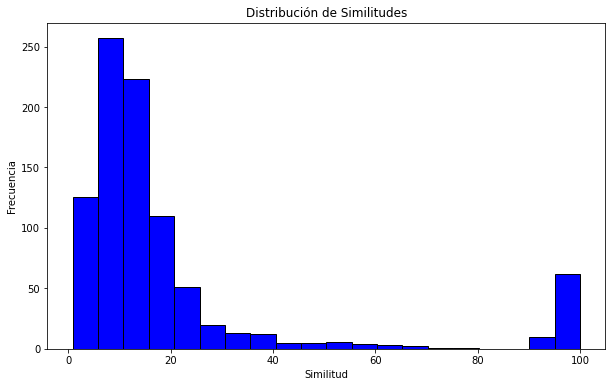

In [259]:
# Visualizar la distribución de similitudes
plt.figure(figsize=(10, 6))
plt.hist(df['Similitud'], bins=20, color='blue', edgecolor='black')
plt.title('Distribución de Similitudes')
plt.xlabel('Similitud')
plt.ylabel('Frecuencia')
plt.show()

In [260]:
df

,Nombre1,Code1,Nombre2,Code2,Similitud,Similitud_Coseno,Distancia_Levenshtein,Distancia_Manhattan,Promedio_Ponderado,Plagio
0,0017d438,import java.io.BufferedReader;\nimport java.io...,9852706b,import java.io.BufferedReader;\nimport java.io...,19.948276,65.986167,93.908235,62.369377,52.793745,1
1,0017d438,import java.io.BufferedReader;\nimport java.io...,ac180326,import java.io.BufferedReader;\nimport java.io...,12.710559,58.223706,91.786918,47.903960,45.699115,0
2,0048a372,import java.io.*;\nimport java.util.*;\n\npubl...,0adb1ee5,import java.util.*;\n// import java.lang.*;\ni...,10.224491,43.734238,92.512745,51.367918,40.849409,0
3,00af3420,import java.util.*;\nimport java.io.*;\n\npubl...,5449d33c,import java.io.*;\nimport java.util.*;\nimport...,13.862249,52.947792,96.254212,56.215158,46.301595,0
4,00af3420,import java.util.*;\nimport java.io.*;\n\npubl...,86102d81,import java.io.*;\nimport java.util.*;\n\t\t\n...,19.701471,57.087980,95.200035,60.856138,50.132603,1
...,...,...,...,...,...,...,...,...,...,...
906,eea69e7f,import java.util.*;\n\npublic class Solution {...,f6ca6fc8,import java.util.*;\nimport java.io.*;\n\npubl...,15.404823,49.469676,97.036205,67.534280,47.163501,0
907,f229aa7f,import java.util.*;\nimport java.io.*;\nimport...,fcc7e8fa,import java.io.OutputStream;\nimport java.io.I...,17.686890,33.898958,93.549641,52.642304,41.218602,0
908,f28b8cb4,import java.io.BufferedReader;\nimport java.io...,ff3283cf,import java.util.*;\nimport java.lang.*;\nimpo...,14.593163,58.860077,94.677266,56.882845,48.119026,0
909,fadc1365,import java.io.PrintWriter;\nimport java.io.Bu...,fdd85afb,import java.util.*;\n\npublic class Solution{\...,9.334347,58.875115,94.033526,59.120000,46.114979,0
